# read data

In [1]:
import json
import operator
import itertools

In [21]:
file_num = [35, 30, 1, 5]
# file_num = [35]

In [22]:
data = []
for f in file_num: 
    print f
    with open("../datasets/raw-data/"+str(f)+".json", 'rb') as infile:
        data.extend(json.load(infile))

35
30
1
5


In [23]:
print len(data)

583


# pre-process (entities)

In [24]:
import pickle_util
import nltk
import re
import pandas as pd
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer

%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


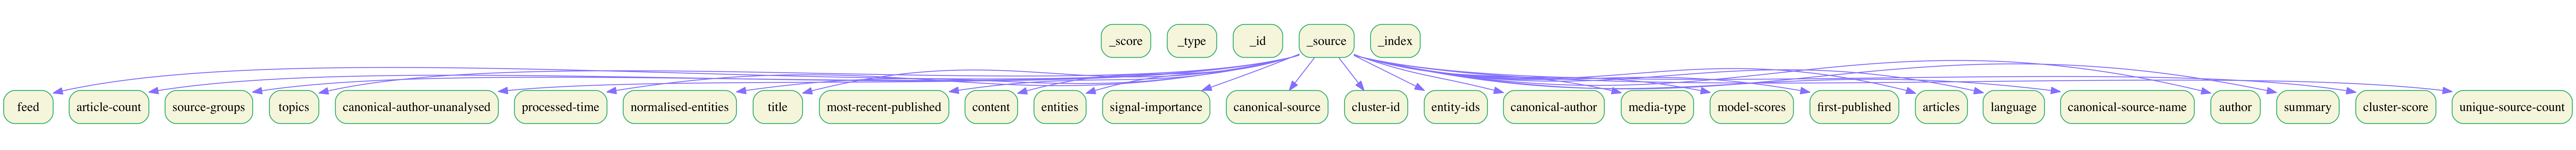

In [25]:
import visualisedictionary as vd
G = vd.KeysGraph(data[0])
G.draw('./doc.png')
from IPython.display import Image
Image('./doc.png')

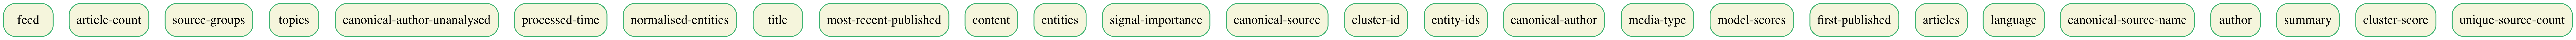

In [26]:
G = vd.KeysGraph(data[0]["_source"])
G.draw('./doc_source.png')
from IPython.display import Image
Image('./doc_source.png')

In [27]:
# tf.idf article signal-entities (surface-form)
docs_entities = []
ids = []
for doc in data:
    d = doc["_source"]
    entities = []
    try:
        for entity in d["normalised-entities"]:
            try: 
                entities.append(entity['surface-form'])
            except:
                continue
        ids.append(doc["_id"])
    except:
        print "0 entities for doc: " + doc["_id"]
        continue
        
#     docs_entities.append(" ".join(entities) + d["title"])
    docs_entities.append(" ".join(entities))
    
entity_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2))
X_entities = entity_vectorizer.fit_transform(docs_entities)
terms_entities = entity_vectorizer.get_feature_names()
print X_entities.shape

(583, 6871)


# Clustering

In [28]:
import pickle_util
import pandas as pd
import numpy as np

from sklearn.externals import joblib

from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift

from tsne import bh_sne

import operator

%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [29]:
def reduce_and_plot_clusters(X, model):
    X_reduced = TruncatedSVD().fit_transform(X)
    X_embedded = TSNE(learning_rate=100).fit_transform(X_reduced)
    # X_pca = PCA().fit_transform(content_mat)
    # Creating a discrete colorbar
#     colors = np.linspace(0, 1, model.n_clusters)
#     fig = figure(figsize=(10, 10))
#     ax = axes(frameon=False)
#     setp(ax, xticks=(), yticks=())
#     subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
#                     wspace=0.0, hspace=0.0)

    n_clus = len(set(model.labels_.tolist()))
    print n_clus

#     scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x", c=model.labels_.tolist(), cmap=cm.rainbow)
    plt.figure(figsize=(10,10))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x", c=model.labels_.tolist(), cmap=plt.cm.get_cmap("jet", n_clus))
    plt.colorbar(ticks=range(n_clus))
    plt.clim(-0.5, (n_clus-0.5))
    plt.show()

In [30]:
def plot_cluster_counts(model):
    label_counts = {}
    for label in model.labels_:
        try:
            label_counts[label] +=1
        except:
            label_counts[label] = 0

    print label_counts
    print type(label_counts.keys()), " ", type(label_counts.values())

    plt.bar(label_counts.keys(), label_counts.values())

In [31]:
dbscan = DBSCAN(metric='cosine', algorithm='brute')
dbscan.fit(X_entities)

DBSCAN(algorithm='brute', eps=0.5, leaf_size=30, metric='cosine',
    min_samples=5, p=None, random_state=None)

13


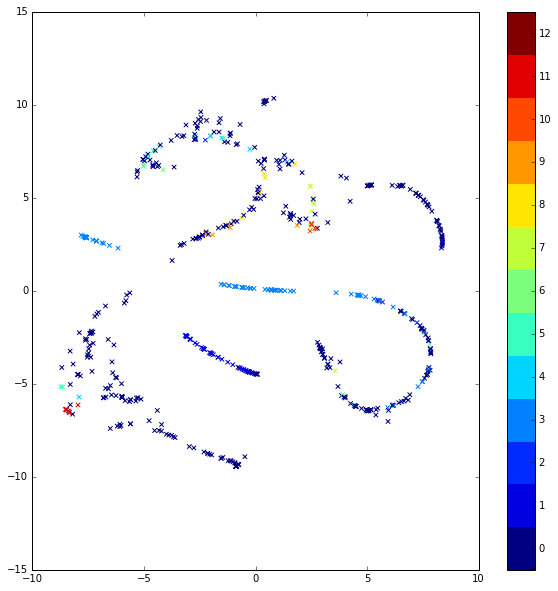

In [32]:
reduce_and_plot_clusters(X_entities, dbscan)

{0: 14, 1: 48, 2: 4, 3: 89, 4: 5, 5: 10, 6: 4, 7: 8, 8: 7, 9: 5, 10: 4, 11: 9, -1: 363}
<type 'list'>   <type 'list'>


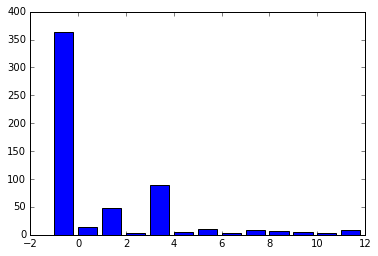

In [33]:
plot_cluster_counts(dbscan)

{0: 86, 1: 65, 2: 429}
<type 'list'>   <type 'list'>
3


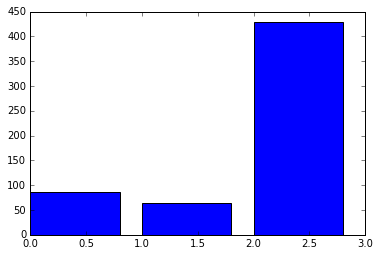

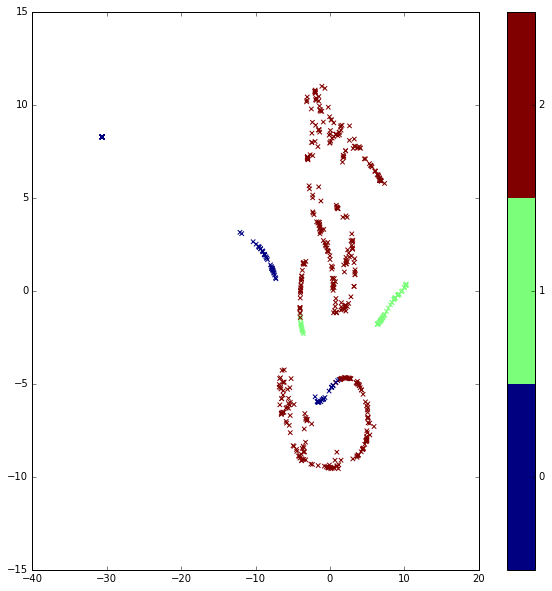

In [35]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_entities)
plot_cluster_counts(kmeans)
reduce_and_plot_clusters(X_entities, kmeans)

# Evaluation

In [36]:
clusters = kmeans.labels_
decisions = ['YES' for x in range(0, len(ids))]

df = pd.DataFrame({'story': ids, 'cluster': clusters, 'decision': decisions})
df['Score'] = 0
df['Nt'] = 0
df

,cluster,decision,story,Score,Nt
0,2,YES,8909a76f-4c19-4b3d-b58a-9e6db917ce40,0,0
1,2,YES,f45fa173-cfb3-4cd7-b8cf-9f4470130b23,0,0
2,2,YES,5e073c47-ec91-496e-acc5-7228b9cde371,0,0
3,2,YES,ce14a151-39a1-4ec0-bb50-039be6b883fc,0,0
4,2,YES,93557c34-49fe-46a7-9d9b-567f1f99ad0f,0,0
5,2,YES,e21d4298-ba54-4f9f-ae99-045561d56e99,0,0
6,2,YES,7fc01584-5679-4cfd-9d8a-76f96e0ba984,0,0
7,2,YES,88b1f076-8195-41a8-9a86-585e17d903dc,0,0
8,2,YES,94a8cbfa-cd77-4654-a701-8412d7598551,0,0
9,2,YES,225f3ef1-88be-41b4-8aab-3e12b42aef83,0,0


In [37]:
df['cluster'].value_counts()

2    430
0     87
1     66
Name: cluster, dtype: int64

In [38]:
eval_list = []
for f in file_num: 
    print f
    eval_list.append(pd.read_csv("../datasets/eval/"+str(f)+".txt", sep='\t', names=['story', 'event', 'decision']))

df_eval = pd.concat(eval_list)
df_eval

35
30
1
5


,story,event,decision
0,ce14a151-39a1-4ec0-bb50-039be6b883fc,41,YES
1,88b1f076-8195-41a8-9a86-585e17d903dc,41,YES
2,dc681378-2149-4fee-a71f-3b91e203e4c9,41,YES
3,3b4d2d37-83f2-4055-9343-dde8a4134ca1,41,YES
4,f0a866ba-0244-4a72-95af-8a0ba1a174b2,41,YES
5,4a494e65-4a7c-4ca7-a068-8e27ecfecc29,41,YES
0,8ccdcd5e-38b8-49e2-b106-eac3b408dd19,35,YES
1,5ecb5c53-8ded-47b5-b542-93d297f847de,35,YES
2,7aacf8cc-2479-4f9c-b3cf-904c730afa54,35,YES
3,caa596a3-f3a4-405f-bfc9-ce49bc236048,35,YES


In [39]:
df_eval['event'].value_counts()

5     149
1      24
35     17
41      6
Name: event, dtype: int64

In [41]:
match = []

for name, group in df.groupby('cluster'):
    max_list = []
    for name_, group_ in df_eval.groupby('event'):
        max_list.append((name_, pd.merge(group, group_, on='story', how='inner').shape[0]))
#     print "cluster: ", name, "max list: ", max_list
    max_event = max(max_list, key=operator.itemgetter(1))
    [max_event_id, max_event_freq] = max_event
    match.append((name, max_event_id, max_event_freq))
    

    
print "match"
print match

eval_clusters = {event: [0, 0] for event in list(df_eval.event.unique())}
# print eval_clusters
    
for m in match:
    if eval_clusters[m[1]][1] < m[2]:
        # update freq, event
        eval_clusters[m[1]][1] = m[2]
        eval_clusters[m[1]][0] = m[0]

print eval_clusters

match
[(0, 5, 69), (1, 1, 5), (2, 5, 80)]
{41: [0, 0], 35: [0, 0], 5: [2, 80], 1: [1, 5]}


In [70]:
# define matrix

eval_clusters = {}

# populate matrix
for i, (name, group) in enumerate(df_eval.groupby('event')):
    print "i: ", i, "Event: ", name
    m = 0
    for j, (name_, group_) in enumerate(df.groupby('cluster')):
        print "j: ", j, "Cluster: ", name_
        n = pd.merge(group, group_, on='story', how='inner').shape[0]
        if n > m:
            m = n
            eval_clusters[name] = (name_, n)

print eval_clusters

    

i:  0 Event:  1
j:  0 Cluster:  0
j:  1 Cluster:  1
j:  2 Cluster:  2
i:  1 Event:  5
j:  0 Cluster:  0
j:  1 Cluster:  1
j:  2 Cluster:  2
i:  2 Event:  35
j:  0 Cluster:  0
j:  1 Cluster:  1
j:  2 Cluster:  2
i:  3 Event:  41
j:  0 Cluster:  0
j:  1 Cluster:  1
j:  2 Cluster:  2
{1: (2, 19), 35: (2, 17), 5: (2, 80), 41: (2, 6)}


In [69]:
clusters

array([2, 1, 0])

In [44]:
len(df['cluster'].unique())

3

In [42]:
df_results = pd.DataFrame(columns=["a", "b", "c", "d", "miss", "f", "r", "p", "f1"])

for i, event in enumerate(eval_clusters):
    max_cluster = eval_clusters[event][0]
    max_event = event
    
    print "Cluster: ", max_cluster, " Event: ", max_event
    
    a = 0.0
    b = 0.0
    c = 0.0
    d = 0.0

    # cluster df
    df_cluster = df[df['cluster'] == max_cluster]
    df_non_cluster = df[~df.story.isin(df_cluster.story)]
    
    df_event = df_eval[df_eval['event'] == max_event]
    df_non_event = df[~df.story.isin(df_event.story)]

    # contingency df
    df_event_cluster = pd.merge(df_event, df_cluster, on='story', how='inner')
    df_non_event_cluster = pd.merge(df_non_event, df_cluster, on='story', how='inner')
    df_event_non_cluster = pd.merge(df_event, df_non_cluster, on='story', how='inner')
    df_non_event_non_cluster = pd.merge(df_non_event, df_non_cluster, on='story', how='inner')
    
    # counts
    a += df_event_cluster.shape[0]
    b += df_non_event_cluster.shape[0]
    c += df_event_non_cluster.shape[0]
    d += df_non_event_non_cluster.shape[0]

#     print a, b, c, d

    # rates
    try:
        miss = c / (a + c)
        f = b / (b + d)
        r = a / (a + c)
        p = a / (a + b)
        f1 = 2 * r * p / (r + p)
    except:
        a = None
        b = None
        c = None
        d = None
        miss = None
        f = None
        r = None
        f1 = None
    
    df_results.loc[i] = [a,b,c,d,miss,f,r,p,f1]

#     print "miss", miss
#     print "f (false alarm)", f 
#     print "r (recall)", r
#     print "p (precision)", p
#     print "f1", f1

# df_results

print "macro"

print df_results[['miss', 'f', 'r', 'p', 'f1']].mean()

print "micro"

print df_results

[a, b, c, d] = df_results[['a', 'b', 'c', 'd']].sum()


 # rates
miss = c / (a + c)
f = b / (b + d)
r = a / (a + c)
p = a / (a + b)
f1 = 2 * r * p / (r + p)

print "miss", miss
print "f (false alarm)", f 
print "r (recall)", r
print "p (precision)", p
print "f1", f1

Cluster:  0  Event:  41
Cluster:  0  Event:  35
Cluster:  2  Event:  5
Cluster:  1  Event:  1
macro
miss    0.627377
f       0.458010
r       0.372623
p       0.065343
f1      0.193487
dtype: float64
micro
    a    b   c    d      miss         f         r         p        f1
0 NaN  NaN NaN  NaN       NaN       NaN       NaN  0.000000       NaN
1 NaN  NaN NaN  NaN       NaN       NaN       NaN  0.000000       NaN
2  80  351  69   84  0.463087  0.806897  0.536913  0.185615  0.275862
3   5   61  19  498  0.791667  0.109123  0.208333  0.075758  0.111111
miss 0.508670520231
f (false alarm) 0.414486921529
r (recall) 0.491329479769
p (precision) 0.171026156942
f1 0.253731343284


In [293]:
print type(list(df_results[['miss', 'f', 'r', 'p', 'f1']].mean()))

<type 'list'>


In [294]:
len(ids) == len(kmeans.labels_)

True

In [299]:
micro_results = pd.DataFrame(
        columns=["miss", "f", "r", "p", "f1"])
micro_results.loc[0] = [miss, f, r, p, f1]
micro_results.reset_index(drop=True).transpose()    

,0
miss,0.235955
f,0.125222
r,0.764045
p,0.080664
f1,0.145923
